# **Project Objective:To decrease Bank Customer Churn**

**Group 7**

**Getrude Shabiha, Hema Ravi Teja Bollam, Sarju Tuladhar**


In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import scipy as sp 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# suppressing warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_excel('Super Market Sales Data.xlsx')

In [3]:
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-05-01 00:00:00,13:08:00,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-08-03 00:00:00,10:29:00,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03 00:00:00,13:23:00,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-08-02 00:00:00,10:37:00,Ewallet,604.17,4.761905,30.2085,5.3


# Correcting the Date Column

In [4]:
df['Date']=df['Date'].astype(str)
df['Date']=df['Date'].str.split(" ",n=1,expand=True)[0]
df['Date']=df['Date'].str.split("-",n=2,expand=False)
df['Date']=df['Date'].apply(lambda x: list(reversed(x)))
df['Date']=df['Date'].agg(lambda x: ','.join(map(str, x)))
df['Date']=df['Date'].replace(',','/',regex=True)
df['Date']=df['Date'].astype('datetime64[ns]')
df['Week_Day'] = df['Date'].dt.day_name()

In [5]:
df['Time']=df['Time'].astype(str)
df['Time']=df['Time'].str.split(":",n=1,expand=True)[0]
df=df.rename({'Time':'Hour'},axis=1)

# Checking for Null Values

In [6]:
# Assuming your DataFrame is named 'df'
# Check for null values in each column
null_columns = df.columns[df.isnull().any()]

# Display the columns with null values
print("Columns with null values:")
print(null_columns)


Columns with null values:
Index([], dtype='object')


# Descriptive Statistics

In [7]:
df.describe() # Statistically summarizes dataframe df

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1.000000e+03,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905e+00,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,6.131498e-14,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905e+00,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905e+00,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905e+00,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905e+00,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905e+00,49.650000,10.00000


# Droping categorical variables with zero variation & high cardinality

In [8]:
# Gives the categorical variables minus the target variable in our dataset
categorical_var = list(set(df.dtypes[df.dtypes == object].index) - set(['Rating']))
categorical_var

['Invoice ID',
 'Gender',
 'Week_Day',
 'Payment',
 'City',
 'Hour',
 'Customer type',
 'Product line',
 'Branch']

In [9]:
# Creates an empty list for categorical variables with zero variation
a = [] 

for i in categorical_var: # for each categorical variables
    if len(df[i].value_counts().index) >=200: # check how many levels it has and if it is one
        a.append(i)
    elif len(df[i].value_counts().index) == 1: 
        a.append(i)
        # append it to the list of categorical variables with zero variation
print(a) # Prints the list of variables with high cardinality



['Invoice ID']


In [10]:
## Note: We will drop any caategorical variable with high variance        
# Note: We will drop any categorical variable with high variance
columns_to_drop = [col for col in a if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Deleting the Numerical variables with zero variance

In [11]:
df.std()

Unit price                                  26.494628
Quantity                                     2.923431
Tax 5%                                      11.708825
Total                                      245.885335
Date                       25 days 02:55:51.497837682
cogs                                        234.17651
gross margin percentage                           0.0
gross income                                11.708825
Rating                                        1.71858
dtype: object

In [12]:
# Calculate the standard deviation for each column, excluding 'Date'
std_devs = df.drop('Date', axis=1).std()

# Set the threshold for standard deviation
threshold = 0.001

# Get the column names (excluding 'Date') with standard deviation below the threshold
columns_to_delete = std_devs[std_devs < threshold].index

# Drop the columns with low standard deviation from the DataFrame
df = df.drop(columns=columns_to_delete)

In [13]:
categorical_var = set(df.dtypes[df.dtypes == object].index)
numerical_var = set(df.dtypes[df.dtypes != object].index)

# Dropping unwanted variables

In [14]:
""""
Why are we deleting the columns?

Co-relation between the columns and they don't help us to draw any conclusions
1) City and Branch are same
2) Tax 5% and gross margin percentage are same
3) Total = Unit Price * Quantity * Tax 5% 
4)  cogs = Unit Price * Quantity

"""
columns_to_delete = ['City', 'Tax 5%', 'gross income', 'cogs']
df = df.drop(columns_to_delete, axis = 1)

In [15]:
categorical_var = set(df.dtypes[df.dtypes == object].index)
numerical_var = set(df.dtypes[df.dtypes != object].index)

# Calculating Range for Numerical variables

In [16]:
numerical_variables = numerical_var
summary_df = pd.DataFrame(columns=['Variable', 'Min', 'Max'])
for variable in numerical_variables:
    min_val = df[variable].min()
    max_val = df[variable].max()
    summary_df = summary_df.append({'Variable': variable, 'Min': min_val, 'Max': max_val}, ignore_index=True)
print(summary_df)

     Variable                  Min                  Max
0      Rating                  4.0                 10.0
1       Total              10.6785              1042.65
2        Date  2019-01-01 00:00:00  2019-03-30 00:00:00
3    Quantity                    1                   10
4  Unit price                10.08                99.96


# Visualizing Data

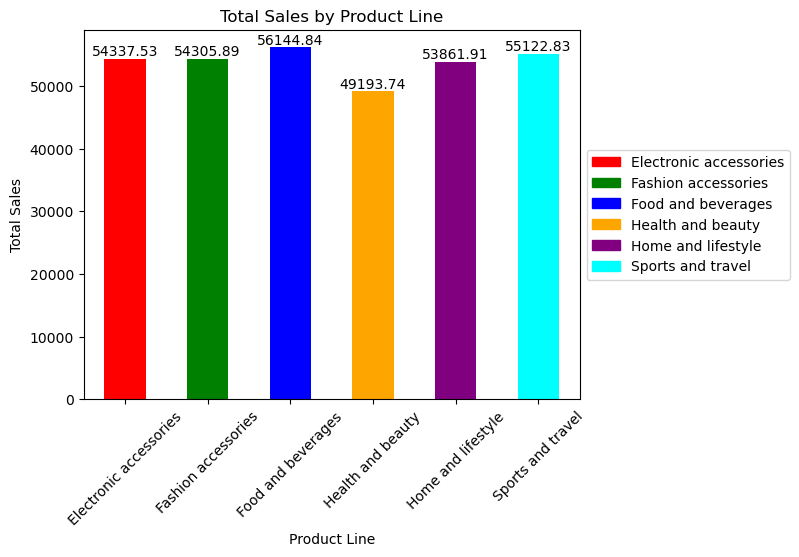

In [17]:
# Analyze sales by product line
sales_by_product_line = df.groupby('Product line')['Total'].sum()

# Define colors for each product line
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']

# Plot sales by product line with multi-color bars
fig, ax = plt.subplots()
sales_by_product_line.plot(kind='bar', color=colors, ax=ax)

# Set x-axis tick labels
ax.set_xticklabels(sales_by_product_line.index, rotation=45)

# Add labels and title
plt.xlabel('Product Line')
plt.ylabel('Total Sales')
plt.title('Total Sales by Product Line')

# Create a custom legend for colors and move it to the right
legend_elements = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
ax.legend(legend_elements, sales_by_product_line.index, loc='center left', bbox_to_anchor=(1, 0.5))

# Add values above each bar
for i, v in enumerate(sales_by_product_line):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()


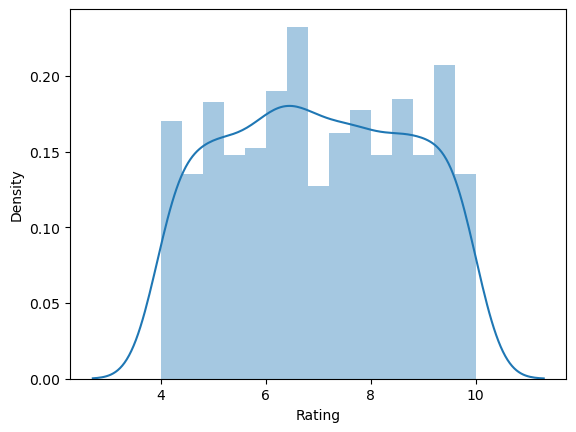

In [18]:
# plots the data on a histogram using seaborn
ax = sns.distplot(df['Rating'], bins = 15) 

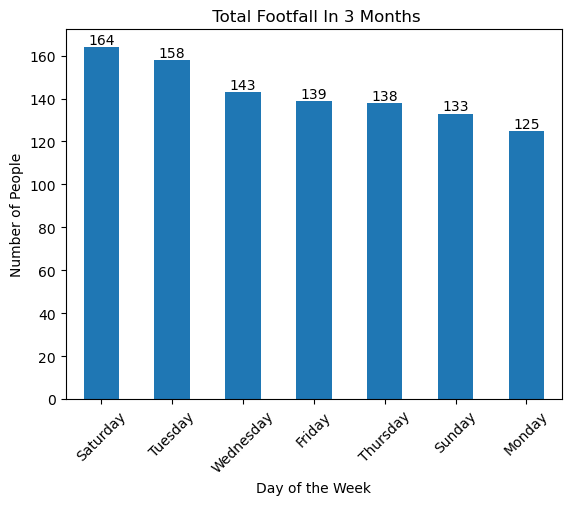

In [19]:
# Calculate total footfall for each day of the week
people_count = df['Week_Day'].value_counts()

# Plot total footfall for each day of the week
people_count.plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Number of People')
plt.title(' Total Footfall In 3 Months')
plt.xticks(rotation=45)

# Add values above each bar
for i, count in enumerate(people_count):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()


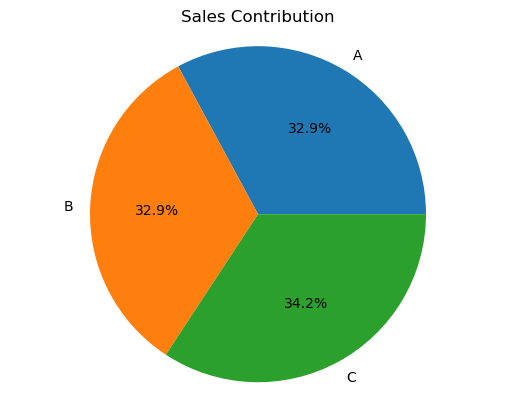

In [20]:
# Group the data by 'Branch' and calculate the total sale in each branch
branch_income = df.groupby('Branch')['Total'].sum()

# Create a pie chart to visualize Sales contribution by each branch
plt.pie(branch_income.values, labels=branch_income.index, autopct='%1.1f%%')
plt.title('Sales Contribution')
plt.axis('equal')
plt.show()


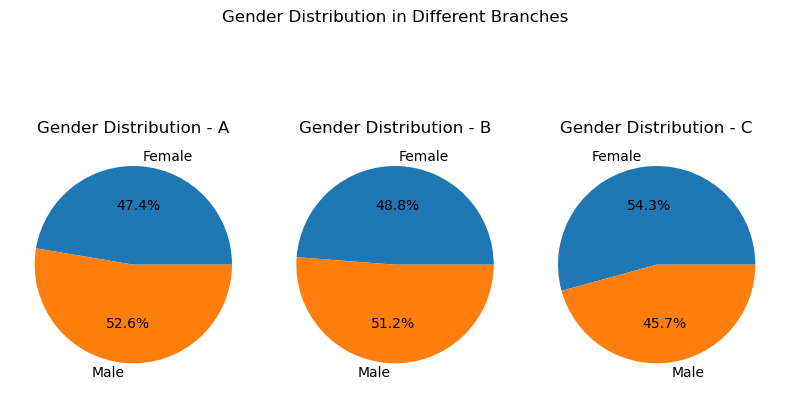

In [21]:
# Group the data by 'Branch' and 'Gender' columns and count the occurrences
gender_counts = df.groupby(['Gender', 'Branch']).size().unstack()

# Get the number of branches
num_branches = len(gender_counts.columns)

# Plot a pie chart for each branch
fig, axs = plt.subplots(1, num_branches, figsize=(8, 5))

# Iterate over each branch and create a pie chart
for i, branch in enumerate(gender_counts.columns):
    ax = axs[i]
    branch_data = gender_counts[branch]
    ax.pie(branch_data, labels=branch_data.index, autopct='%1.1f%%')
    ax.set_title(f'Gender Distribution - {branch}')

# Set the overall title for the subplots
fig.suptitle('Gender Distribution in Different Branches')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


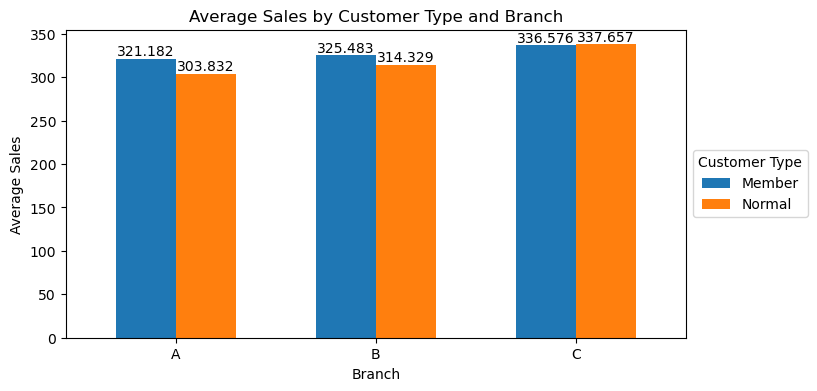

In [22]:
# Group the data by 'Branch', 'Customer type', and calculate the avg of 'Total'
grouped_data = df.groupby(['Branch', 'Customer type'])['Total'].mean()

# Reset the index to convert the grouped data into a DataFrame
grouped_data = grouped_data.reset_index()

# Pivot the data to have 'Customer type' as columns and 'Branch' as rows
pivot_data = grouped_data.pivot(index='Branch', columns='Customer type', values='Total')

# Plotting the data
ax = pivot_data.plot(kind='bar', figsize=(8, 4), width=0.6)  # Adjust the width as desired
plt.title('Average Sales by Customer Type and Branch')
plt.xlabel('Branch')
plt.ylabel('Average Sales')

# Rotate the x-axis labels
plt.xticks(rotation=0)

# Add labels and values to the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, color='black')
plt.legend(title='Customer Type', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


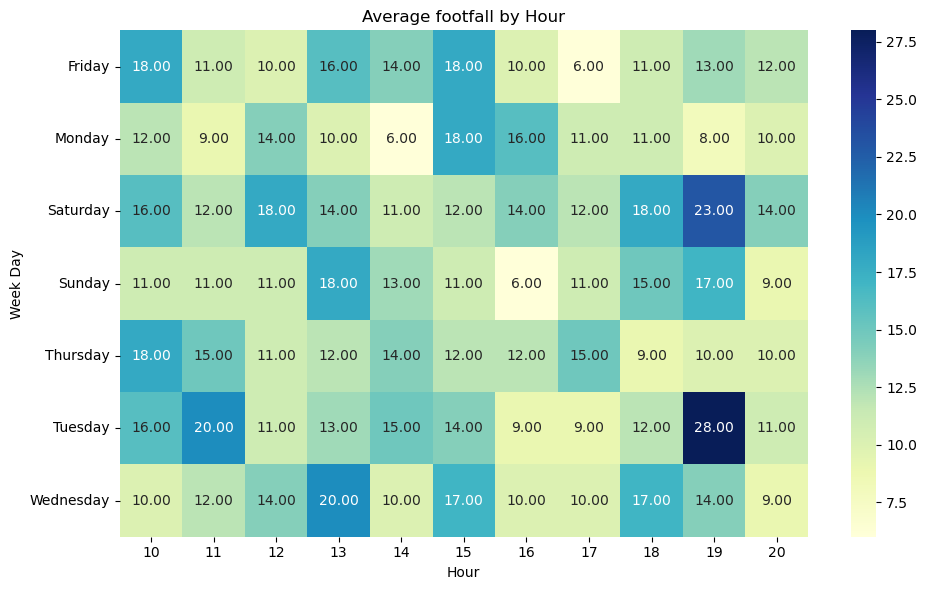

In [23]:
# Calculate the average Total sale by hour
average_footfall_by_hour = df.pivot_table(values='Total', index='Week_Day', columns='Hour', aggfunc='count')

# Sort the columns in ascending order
average_footfall_by_hour = average_footfall_by_hour.reindex(sorted(average_footfall_by_hour.columns), axis=1)

# Draw the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(average_footfall_by_hour, cmap='YlGnBu', annot=True, fmt='.2f', cbar=True)
plt.title('Average footfall by Hour')
plt.xlabel('Hour')
plt.ylabel('Week Day')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


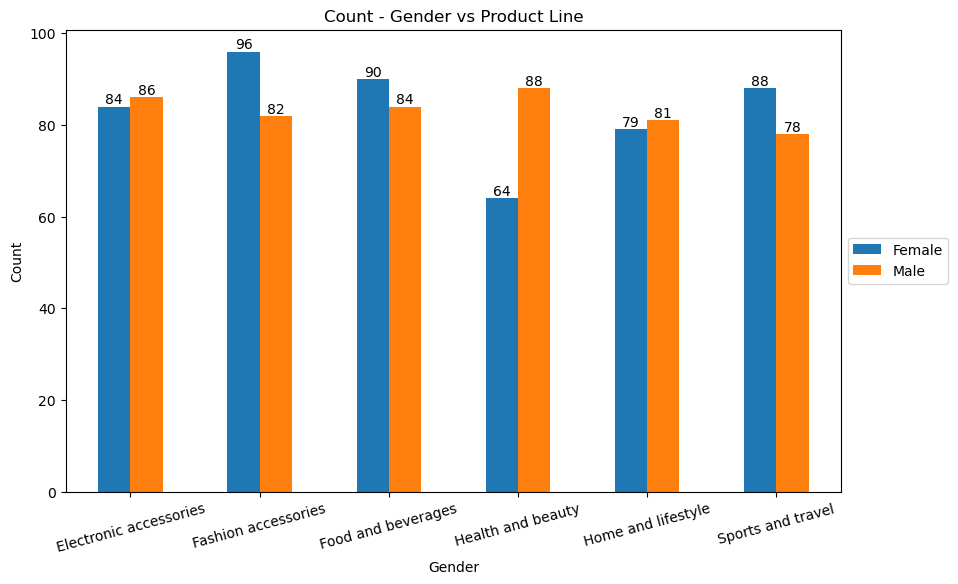

In [24]:
# Count the occurrences of each combination of Gender and Product line
counts = df.groupby(['Product line', 'Gender']).size().unstack()

# Create a bar graph
ax = counts.plot(kind='bar', stacked=False, figsize=(10, 6))

# Set the axis labels and title
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count - Gender vs Product Line')

# Set the legend outside the plot area and adjust the position
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation= 15)
# Display the values above each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.show()


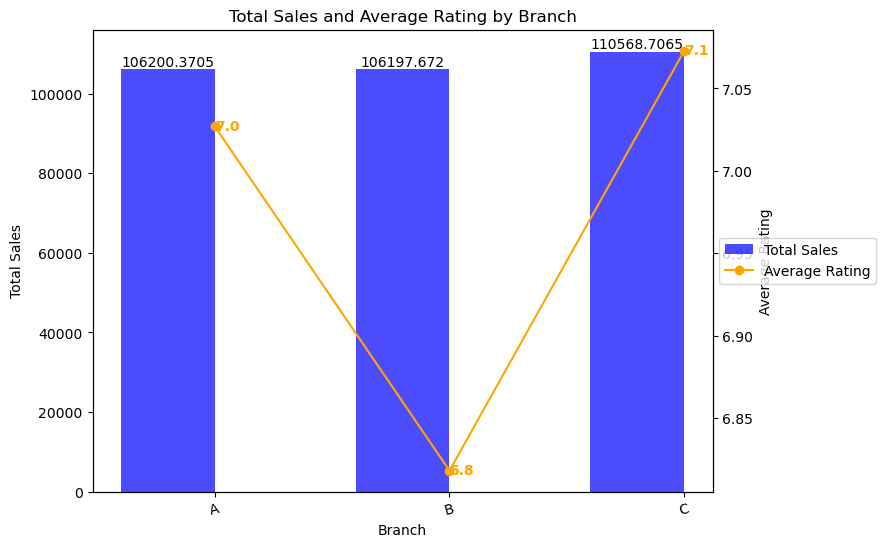

In [25]:

# Group the data by 'Branch' and calculate total sales and average rating
grouped_data = df.groupby('Branch').agg({'Total': 'sum', 'Rating': 'mean'}).reset_index()
grouped_data.columns = ['Branch', 'Total_Sales', 'Average Rating']

# Set the figure size
fig, ax1 = plt.subplots(figsize=(8, 6))

# Define the x-axis positions for the bars
x = np.arange(len(grouped_data))

# Plot the bar graph for total sales
bar_width = 0.4
ax1.bar(x - bar_width/2, grouped_data['Total_Sales'], width=bar_width, color='blue', alpha=0.7, label='Total Sales')

# Set the y-axis label for total sales
ax1.set_ylabel('Total Sales')

# Create a twin Axes for average rating
ax2 = ax1.twinx()

# Plot the line graph for average rating
ax2.plot(x, grouped_data['Average Rating'], color='orange', marker='o', label='Average Rating')

# Set the y-axis label for average rating
ax2.set_ylabel('Average Rating')

# Set the x-axis labels and tick positions
ax1.set_xticks(x)
ax1.set_xticklabels(grouped_data['Branch'], rotation=15)
ax1.set_xlabel('Branch')

# Display the values on top of each bar
for i, total_sales in enumerate(grouped_data['Total_Sales']):
    ax1.text(i - bar_width/2, total_sales + 0.5, total_sales, ha='center', va='bottom')

# Display the values at the right side of each point on the line graph
for i, rating in enumerate(grouped_data['Average Rating']):
    ax2.text(i, rating, f"{round(rating, 1)}", ha='left', va='center', color='orange', fontweight='bold')

# Set the title
plt.title('Total Sales and Average Rating by Branch')

# Move the legend to the outside
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

# Scatter Plot Matrix

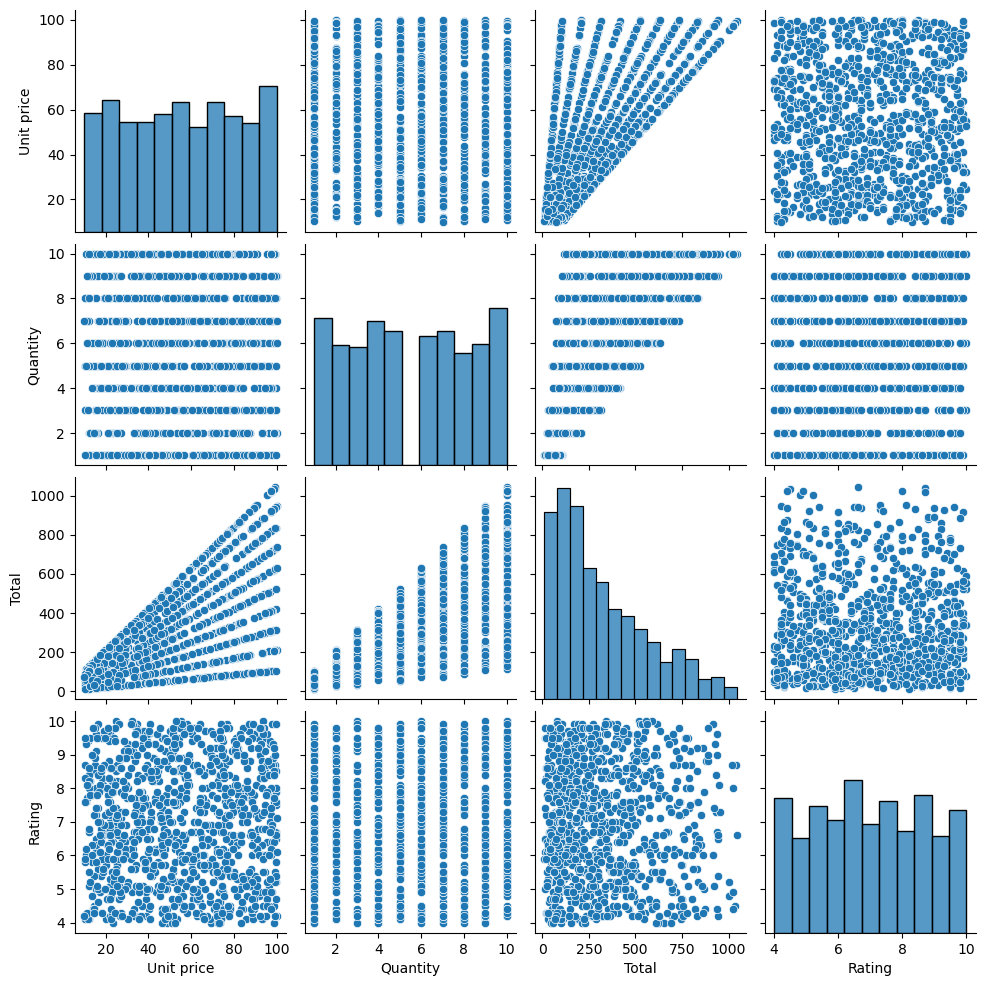

In [26]:
sns.pairplot(df) # Create pairwise scatter plots for numerical columns plt.show()

# Correlation Matrix & Plot - Numerical Variables

In [27]:
#Correlation matrix
corr_matrix = df.corr()
print("Correlation Matrix:\n", corr_matrix)

Correlation Matrix:
             Unit price  Quantity     Total    Rating
Unit price    1.000000  0.010778  0.633962 -0.008778
Quantity      0.010778  1.000000  0.705510 -0.015815
Total         0.633962  0.705510  1.000000 -0.036442
Rating       -0.008778 -0.015815 -0.036442  1.000000


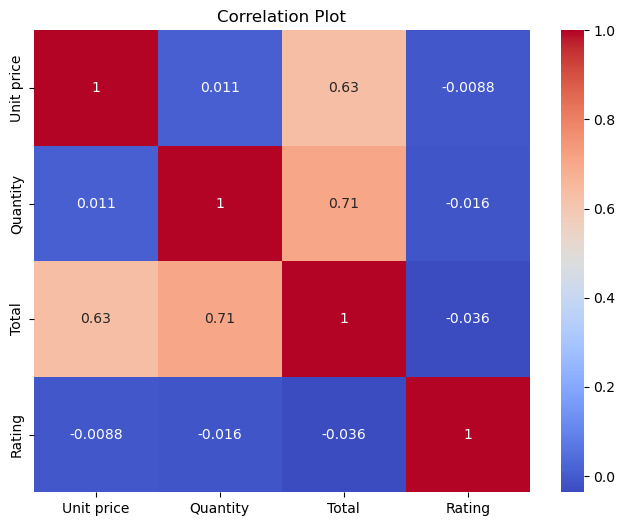

In [28]:
#Correlation plot
plt.figure(figsize=(8, 6)) 
sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm') 
plt.title('Correlation Plot')
plt.show()

# Scaling The Numerical Variables

In [29]:
# Extracts the numerical values
numerical_val = set(df.dtypes[df.dtypes != object].index)
numerical_val = list(numerical_val -  set(['Date','Rating']))
numerical_val

['Unit price', 'Quantity', 'Total']

In [30]:
# imports the preprocessing library
from sklearn import preprocessing 

# converts pandas df to numpy array
array = df[numerical_val].values 

# creates a min max scaler
data_scaler = preprocessing.MinMaxScaler(feature_range=(0,1)) 

# Scales the data and overwrites it into the existing dataframe
df[numerical_val] = pd.DataFrame(data_scaler.fit_transform(array), 
                                 columns = numerical_val)

# Immputing Outliers

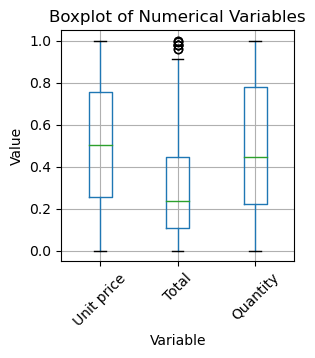

In [31]:
# Extract the numerical variables
numeric_vars = ['Unit price', 'Total', 'Quantity']

# Create a boxplot for each numerical variable
plt.figure(figsize=(3, 3))
df[numeric_vars].boxplot()
plt.title('Boxplot of Numerical Variables')
plt.ylabel('Value')
plt.xlabel('Variable')
plt.xticks(rotation=45)
plt.show()

In [32]:
# Calculate the IQR for each numerical variable
iqr_values = {}
for var in numeric_vars:
    q1 = np.percentile(df[var], 25)
    q3 = np.percentile(df[var], 75)
    iqr = q3 - q1
    iqr_values[var] = iqr

# Display the IQR values
for var, iqr in iqr_values.items():
    print(f"IQR for {var}: {iqr}")


IQR for Unit price: 0.5013351134846462
IQR for Total: 0.33617970554419374
IQR for Quantity: 0.5555555555555555


In [33]:
# Calculate the IQR for each numerical variable
iqr_values = {}
for var in numeric_vars:
    q1 = np.percentile(df[var], 25)
    q3 = np.percentile(df[var], 75)
    iqr = q3 - q1
    iqr_values[var] = iqr

# Find and replace extreme values
for var in numeric_vars:
    q3 = np.percentile(df[var], 75)
    threshold = q3 + 1.5 * iqr_values[var]
    df.loc[df[var] > threshold, var] = threshold

# Display the modified dataset
print(df)


    Branch Customer type  Gender            Product line  Unit price  \
0        A        Member  Female       Health and beauty    0.718847   
1        C        Normal  Female  Electronic accessories    0.057855   
2        A        Normal    Male      Home and lifestyle    0.403316   
3        A        Member    Male       Health and beauty    0.535603   
4        A        Normal    Male       Sports and travel    0.848131   
..     ...           ...     ...                     ...         ...   
995      C        Normal    Male       Health and beauty    0.336782   
996      B        Normal  Female      Home and lifestyle    0.971295   
997      A        Member    Male      Food and beverages    0.242101   
998      A        Normal    Male      Home and lifestyle    0.620160   
999      A        Member  Female     Fashion accessories    0.870717   

     Quantity     Total       Date Hour      Payment  Rating  Week_Day  
0    0.666667  0.521616 2019-01-05   13      Ewallet     9.1  

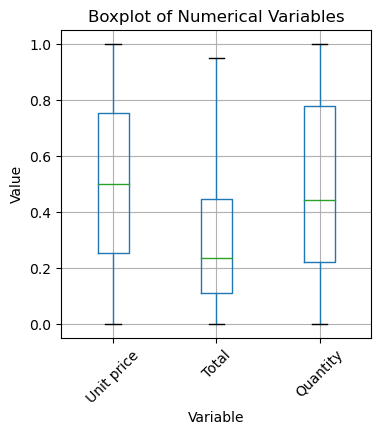

In [34]:
# Create a boxplot for each numerical variable
plt.figure(figsize=(4, 4))
df[numeric_vars].boxplot()
plt.title('Boxplot of Numerical Variables')
plt.ylabel('Value')
plt.xlabel('Variable')
plt.xticks(rotation=45)
plt.show()

# Standardizing Numerical Variables

In [35]:
# Extracts the numerical values
numerical_val = set(df.dtypes[df.dtypes != object].index)
numerical_val = list(numerical_val -  set(['Date','Rating']))
numerical_val

['Unit price', 'Quantity', 'Total']

In [36]:
# Create column names for standardized values
new_cols = [var + '_standardized' for var in numeric_vars]

# Convert the selected columns to a numpy array
array = df[numeric_vars].values

# Create a StandardScaler instance
scaler = StandardScaler()

# Standardize the numerical variables
df[new_cols] = pd.DataFrame(scaler.fit_transform(array), columns=new_cols)

# Display the first five records
df.head()


,Branch,Customer type,Gender,Product line,Unit price,Quantity,Total,Date,Hour,Payment,Rating,Week_Day,Unit price_standardized,Total_standardized,Quantity_standardized
0,A,Member,Female,Health and beauty,0.718847,0.666667,0.521616,2019-01-05,13,Ewallet,9.1,Saturday,0.718160,0.923780,0.509930
1,C,Normal,Female,Electronic accessories,0.057855,0.444444,0.067387,2019-03-08,10,Cash,9.6,Friday,-1.525303,-0.989792,-0.174540
2,A,Normal,Male,Home and lifestyle,0.403316,0.666667,0.319628,2019-03-03,13,Credit card,7.4,Sunday,-0.352781,0.072846,0.509930
3,A,Member,Male,Health and beauty,0.535603,0.777778,0.463549,2019-01-27,20,Ewallet,8.4,Sunday,0.096214,0.679156,0.852165
4,A,Normal,Male,Sports and travel,0.848131,0.666667,0.604377,2019-02-08,10,Ewallet,5.3,Friday,1.156959,1.272434,0.509930


In [37]:
df = df.drop(numeric_vars, axis=1)
df.head()

,Branch,Customer type,Gender,Product line,Date,Hour,Payment,Rating,Week_Day,Unit price_standardized,Total_standardized,Quantity_standardized
0,A,Member,Female,Health and beauty,2019-01-05,13,Ewallet,9.1,Saturday,0.718160,0.923780,0.509930
1,C,Normal,Female,Electronic accessories,2019-03-08,10,Cash,9.6,Friday,-1.525303,-0.989792,-0.174540
2,A,Normal,Male,Home and lifestyle,2019-03-03,13,Credit card,7.4,Sunday,-0.352781,0.072846,0.509930
3,A,Member,Male,Health and beauty,2019-01-27,20,Ewallet,8.4,Sunday,0.096214,0.679156,0.852165
4,A,Normal,Male,Sports and travel,2019-02-08,10,Ewallet,5.3,Friday,1.156959,1.272434,0.509930


In [38]:
numerical_val = set(df.dtypes[df.dtypes != object].index)
numerical_val = list(numerical_val -  set(['Date','Rating']))
numerical_val

['Unit price_standardized', 'Total_standardized', 'Quantity_standardized']

# Binarizing Numerical Variables

In [39]:
col_names = [] # Creates a list that defines the column names of new binarized variables
for i in numerical_val: # for each numerical variables
    col_names.append(i + '_binarized') # adds _binarized characters


In [40]:
array = df[numerical_val].values

In [41]:
# Imports the Binarizer lib
from sklearn.preprocessing import Binarizer

# Creates a binarizer instance
binarizer = Binarizer(threshold=0).fit(array) 

# Binarizes the numerical variables and saves tye result as a df
Data_binarized = pd.DataFrame(binarizer.transform(array), columns = col_names) 

In [42]:
# Combines the two dataframes 
df = pd.concat([df, Data_binarized], axis = 1) 

# Creating Dummy Variables for Categorical Variables

In [43]:
# Example to convert categorical variables into dummy variables
categorical_var = list(set(df.dtypes[df.dtypes == object].index))
categorical_var

['Gender',
 'Week_Day',
 'Payment',
 'Product line',
 'Customer type',
 'Hour',
 'Branch']

In [44]:
# Create dummy variables using onehot encoding
dummy_cat_df = pd.get_dummies(df[categorical_var], drop_first=True) 

In [45]:
# Drops categorical variables from the df
df = df.drop(categorical_var, axis = 1) 

# Adds the newly created dummy variables instead
df = pd.concat([df, dummy_cat_df], axis = 1) 

# Transforming Target Variable to Binary Variable

In [46]:
df.loc[df['Rating'] <= 5, 'Rating'] = 0 # assigns 1 to churned customers
df.loc[df['Rating'] > 5, 'Rating'] = 1 # assigns 0 to not-churned customers

In [47]:
df['Rating'].value_counts()

1.0    826
0.0    174
Name: Rating, dtype: int64

# Balancing The Data

In [48]:
df = df.drop('Date', axis=1)

In [49]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0) # using the smote technique 
# (somehow oversampling) to balance the data

input_var = list(set(df.columns) - set(['Rating'])) # sets the input var

X, Y = os.fit_resample(df[df.columns.difference(['Rating'])], df['Rating']) # oversamples the data
X = pd.DataFrame(X, columns = input_var) # makes the X array as a dataframe
Y = pd.DataFrame(Y, columns = ['Rating']) # makes the Y array as a dataframe

df = pd.concat([X, Y], axis=1) # Combine X and Y

# Building Classification Models

In [50]:
models = ['LogisticReg', 'DecisionTree', 'RandomForest', 'KNN'] # models that will be built

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [52]:
# Logistic Regression
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr') # creates a lR instance
lr.fit(X_train, Y_train)

LogisticRegression(multi_class='ovr', random_state=0)

In [53]:
# Decision Trees
dt = DecisionTreeClassifier(criterion = 'gini', splitter='best', max_depth=15)
dt.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=15)

In [54]:
# Random Forests
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [55]:
# K-NN
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)

KNeighborsClassifier()

# Evaluating Performance of Classification Models

In [56]:
# computes the confusion matrix and performence indicators
def get_performance(actual_Y, pred_Y):
    cm = confusion_matrix(actual_Y, pred_Y)
    total = sum(sum(cm))
    accuracy = (cm[0,0]+cm[1,1])/total
    sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
    specificity = cm[1,1]/(cm[1,0]+cm[1,1])
    return accuracy, sensitivity, specificity

In [57]:
pred_Y_lr = lr.predict(X_test) # predicts the Y given the fitted model lr

pred_Y_dt = dt.predict(X_test) # predicts the Y given the fitted model dt

pred_Y_rf = rf.predict(X_test) # predicts the Y given the fitted model rf

pred_Y_knn = knn.predict(X_test) # predicts the Y given the fitted model knn

In [58]:
# accuracy, sensitivity, aand specificity for model lr
accuracy_lr, sensitivity_lr, specificity_lr = get_performance(Y_test, pred_Y_lr)


# accuracy, sensitivity, aand specificity for model dt
accuracy_dt, sensitivity_dt, specificity_dt = get_performance(Y_test, pred_Y_dt)


# accuracy, sensitivity, aand specificity for model rf
accuracy_rf, sensitivity_rf, specificity_rf = get_performance(Y_test, pred_Y_rf)

# accuracy, sensitivity, aand specificity for model knn
accuracy_knn, sensitivity_knn, specificity_knn = get_performance(Y_test, pred_Y_knn)

In [59]:
# Builds a dataframe using the performance indicators so that we can compare the models easily

perf = pd.DataFrame([accuracy_lr, accuracy_dt,accuracy_rf,accuracy_knn], 
                    columns = ['accuracy'], 
                    index = ['Logistic Regression',
                             'Decision Trees', 'Random Forest','K-NN'])

perf['sensitivity'] = np.asarray([sensitivity_lr,
                                  sensitivity_dt, 
                                  sensitivity_rf,
                                  sensitivity_knn])

perf['specificity'] = np.asarray([specificity_lr,
                                  specificity_dt,
                                  specificity_rf,
                                  specificity_knn])

perf

,accuracy,sensitivity,specificity
Logistic Regression,0.844322,0.797794,0.890511
Decision Trees,0.761905,0.827206,0.697080
Random Forest,0.796703,0.812500,0.781022
K-NN,0.688645,0.988971,0.390511


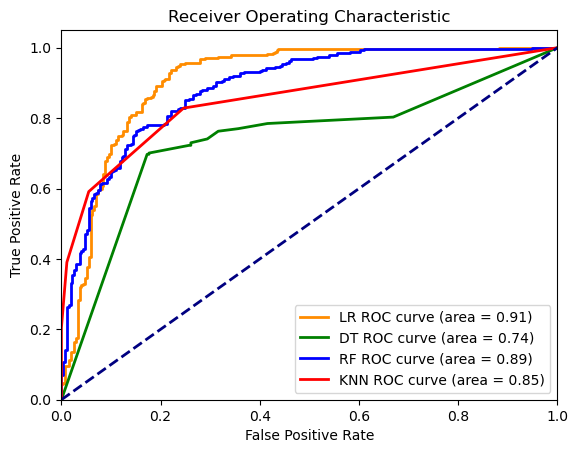

In [60]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC for lr
score_Y_lr = lr.predict_proba(X_test)
fpr_lr, tpr_lr, _ = roc_curve(Y_test, score_Y_lr[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Calculate ROC curve and AUC for dt
score_Y_dt = dt.predict_proba(X_test)
fpr_dt, tpr_dt, _ = roc_curve(Y_test, score_Y_dt[:, 1])
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Calculate ROC curve and AUC for rf
score_Y_rf = rf.predict_proba(X_test)
fpr_rf, tpr_rf, _ = roc_curve(Y_test, score_Y_rf[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Calculate ROC curve and AUC for knn
score_Y_knn = knn.predict_proba(X_test)
fpr_knn, tpr_knn, _ = roc_curve(Y_test, score_Y_knn[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC curves
plt.figure()
lw = 2
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=lw, label='LR ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot(fpr_dt, tpr_dt, color='green', lw=lw, label='DT ROC curve (area = %0.2f)' % roc_auc_dt)
plt.plot(fpr_rf, tpr_rf, color='blue', lw=lw, label='RF ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_knn, tpr_knn, color='red', lw=lw, label='KNN ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [61]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [62]:
model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [63]:
Y_pred = model.predict(X_test)

In [64]:
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100))

Accuracy: 84.80%


# Developing Clustering Models

In [65]:
## Fit Hierarchical Clustering

from matplotlib import pyplot as plt # import the matplotlib library

from scipy.cluster.hierarchy import dendrogram, linkage 
# import the linkage clustering and dendogram methods

import numpy as np

Z = linkage(df, 'single') # cluster the dataset using single linkage method

print(Z) # this gives contains 4 columns
# Z cluster linkage array (contains the hierarchical clustering information)

# We can see that each row of the resulting array has the format 
# [idx1, idx2, dist, sample_count].
# Z[0] = 333 is basically the first cluster

[[1.12000000e+03 1.29900000e+03 3.67035894e-05 2.00000000e+00]
 [1.11600000e+03 1.59900000e+03 1.43845292e-04 2.00000000e+00]
 [1.38800000e+03 1.52500000e+03 3.27542421e-04 2.00000000e+00]
 ...
 [4.02000000e+02 3.29900000e+03 2.25518826e+00 1.65000000e+03]
 [6.62000000e+02 3.30000000e+03 2.27098758e+00 1.65100000e+03]
 [8.00000000e+01 3.30100000e+03 2.30627765e+00 1.65200000e+03]]


In [66]:
Z_small = linkage(df[:80], 'single')
Z_small

array([[ 32.        ,  68.        ,   1.66065742,   2.        ],
       [  1.        ,  79.        ,   1.74614928,   2.        ],
       [  4.        ,  74.        ,   1.93553997,   2.        ],
       [ 80.        ,  82.        ,   1.93753967,   4.        ],
       [ 14.        ,  55.        ,   1.94546832,   2.        ],
       [  0.        ,  38.        ,   1.94999746,   2.        ],
       [ 17.        ,  83.        ,   1.97648331,   5.        ],
       [ 10.        ,  52.        ,   2.00493542,   2.        ],
       [ 49.        ,  78.        ,   2.01516778,   2.        ],
       [ 12.        ,  23.        ,   2.07109157,   2.        ],
       [  8.        ,  60.        ,   2.0751922 ,   2.        ],
       [ 29.        ,  65.        ,   2.07641835,   2.        ],
       [ 21.        ,  33.        ,   2.07717052,   2.        ],
       [ 57.        ,  86.        ,   2.08940958,   6.        ],
       [ 42.        ,  62.        ,   2.11089961,   2.        ],
       [ 26.        ,  53

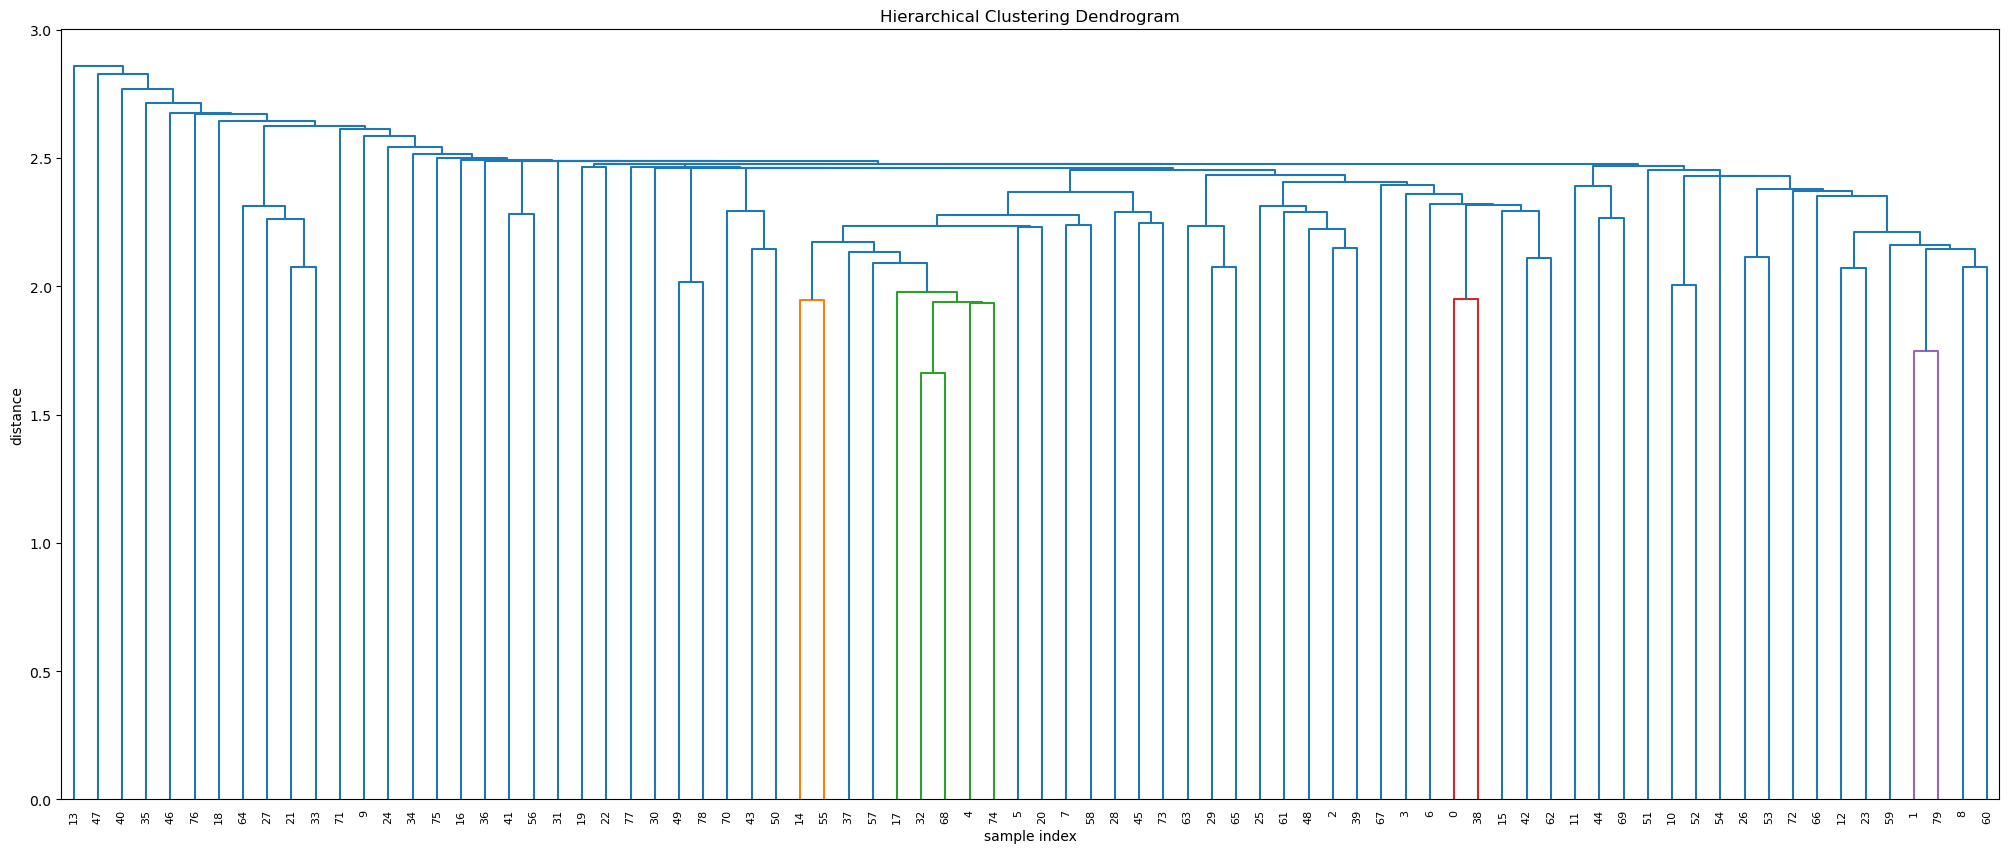

In [67]:
plt.figure(figsize=(25, 10)) # determine the figure size

plt.title('Hierarchical Clustering Dendrogram') # named the plot

plt.xlabel('sample index') # name the x axis

plt.ylabel('distance') # names the y axis

Z_small = linkage(df[:80], 'single')

# plots a dendrogram
dendrogram(
    Z_small,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show() # shows the plot

In [68]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

k = 2 # sets the maximum number of clusters

fcluster(Z, k, criterion='maxclust') # runs the clustering based on maximum cluster

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [69]:
df['clusters'] = fcluster(Z, k, criterion='maxclust') # adds a column to the df that shows
# the cluster of each entries
df['clusters'].value_counts()

1    1651
2       1
Name: clusters, dtype: int64

In [70]:
df.groupby('clusters').mean().T

clusters,1,2
Product line_Health and beauty,0.116293,1.000000
Hour_14,0.055724,1.000000
Hour_15,0.069655,0.000000
Branch_C,0.282859,1.000000
Product line_Home and lifestyle,0.135070,0.000000
Hour_16,0.055724,0.000000
Hour_11,0.067232,0.000000
Hour_17,0.050273,0.000000
Total_standardized_binarized,0.418994,1.000000
Customer type_Normal,0.405209,1.000000


In [71]:
## Fit K-means

from sklearn.cluster import KMeans # import KMeans

model = KMeans(n_clusters = 3) # Creates a KMeans instance where K = 6

model.fit(df) # fits the KMeans using the normalized data

labels = model.labels_ # extracts the classes

In [72]:
labels + 1 # (classes start from 0 so adding one makes it easier to interpret)

array([2, 3, 3, ..., 3, 1, 1])

In [73]:
df['2-means'] = labels+1 # adds a column showing the class membership values 
# to the existing dataframe
df['2-means'].value_counts()# prints the last five records

3    670
2    557
1    425
Name: 2-means, dtype: int64

In [74]:
df.groupby('2-means').mean().T
# computes the mean of columns by the levels of the 3-means variable
# use this one to evaluate the result of your clustering
# how clusters differ among different attributes
# After each clustering algorithm, you need to compare the clusters so that you can profile 
# and interpret the  results. 
# To do so, it is important to compare the median or mean of the variables across clusters

2-means,1,2,3
Product line_Health and beauty,0.110588,0.107720,0.128358
Hour_14,0.035294,0.077199,0.052239
Hour_15,0.063529,0.055655,0.085075
Branch_C,0.268235,0.298025,0.280597
Product line_Home and lifestyle,0.112941,0.170557,0.119403
Hour_16,0.072941,0.048474,0.050746
Hour_11,0.089412,0.059246,0.059701
Hour_17,0.047059,0.059246,0.044776
Total_standardized_binarized,0.245111,0.999316,0.047714
Customer type_Normal,0.355294,0.364452,0.471642


In [75]:
X = df.copy()

distorsions = []
for k in range(1, 10): # we will fit multple k-means (from k = 2 to k = 30)
    kmeans = KMeans(n_clusters=k) # creates a k-means instance
    kmeans.fit(X) # fits k-means
    distorsions.append(kmeans.inertia_)

In [76]:
distorsions

[12724.826490123014,
 9530.70691633531,
 7489.67893106988,
 6833.930876911637,
 6536.496314658265,
 6338.74169257764,
 6182.622573954847,
 6063.880866302851,
 5945.158308620243]

In [77]:
df.columns

Index(['Product line_Health and beauty', 'Hour_14', 'Hour_15', 'Branch_C',
       'Product line_Home and lifestyle', 'Hour_16', 'Hour_11', 'Hour_17',
       'Total_standardized_binarized', 'Customer type_Normal', 'Branch_B',
       'Unit price_standardized_binarized', 'Product line_Food and beverages',
       'Gender_Male', 'Hour_19', 'Unit price_standardized',
       'Week_Day_Wednesday', 'Quantity_standardized', 'Week_Day_Monday',
       'Week_Day_Tuesday', 'Total_standardized', 'Week_Day_Saturday',
       'Hour_13', 'Hour_18', 'Product line_Fashion accessories',
       'Week_Day_Thursday', 'Product line_Sports and travel',
       'Payment_Ewallet', 'Payment_Credit card', 'Hour_12', 'Hour_20',
       'Quantity_standardized_binarized', 'Week_Day_Sunday', 'Rating',
       'clusters', '2-means'],
      dtype='object')

Text(0.5, 1.0, 'Elbow curve')

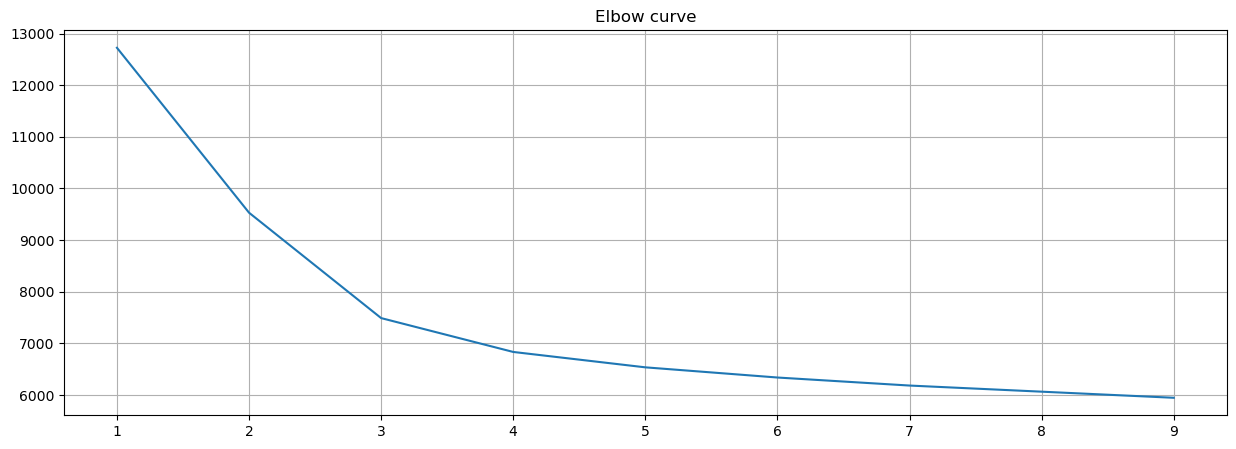

In [78]:
X = df.copy() # copy the normalized_df and save it to a variable named X

distorsions = [] # create an empty list named distorsions

for k in range(1, 10): # we will fit multple k-means (from k = 2 to k = 30)
    kmeans = KMeans(n_clusters=k) # creates a k-means instance
    kmeans.fit(X) # fits k-means
    distorsions.append(kmeans.inertia_) # saves the distorsions

fig = plt.figure(figsize=(15, 5)) # create a figure space with a given figure size

plt.plot(range(1, 10), distorsions) #  # plot the distorsions

plt.grid(True) # inserts grids 

plt.title('Elbow curve') # title the plot

# This curve helps us determine the number of clusters (somehow optimally)

In [79]:
## Fit K-means
model = KMeans(n_clusters = 6) # appears that 2 is the optimal number of classes

model.fit(df) # fits the model

labels = model.labels_ #extracts the class labels

In [80]:
df['optimum_clusters'] = labels+1 # for easy interpretation, adding 1 to class labels
df['optimum_clusters'].value_counts()

1    407
6    333
4    319
5    257
2    226
3    110
Name: optimum_clusters, dtype: int64

In [81]:
df.groupby('optimum_clusters').mean().T

# computes the mean of columns by the levels of the 3-means variable
# use this one to evaluate the result of your clustering
# how clusters differ among different attributes
# After each clustering algorithm, you need to compare the clusters so that you can profile 
# and interpret the  results. 
# To do so, it is important to compare the median or mean of the variables across clusters

optimum_clusters,1,2,3,4,5,6
Product line_Health and beauty,0.108108,0.123894,0.072727,0.122257,0.159533,0.099099
Hour_14,0.061425,0.088496,0.027273,0.037618,0.035019,0.072072
Hour_15,0.088452,0.048673,0.045455,0.068966,0.081712,0.060060
Branch_C,0.235872,0.252212,0.354545,0.241379,0.357977,0.321321
Product line_Home and lifestyle,0.122850,0.115044,0.109091,0.112853,0.116732,0.207207
Hour_16,0.046683,0.075221,0.118182,0.056426,0.054475,0.033033
Hour_11,0.054054,0.057522,0.136364,0.072100,0.070039,0.060060
Hour_17,0.039312,0.061947,0.045455,0.047022,0.050584,0.060060
Total_standardized_binarized,0.000599,0.998315,0.939170,0.015246,0.100095,1.000000
Customer type_Normal,0.469287,0.438053,0.363636,0.351097,0.474708,0.318318


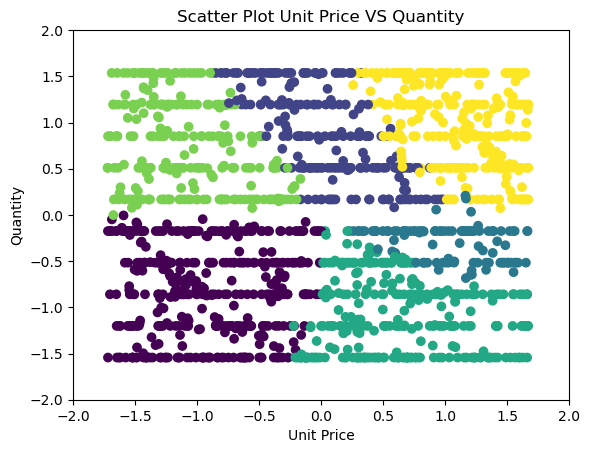

In [82]:
plt.scatter(x=df['Unit price_standardized'],y=df['Quantity_standardized'],c=df['optimum_clusters'])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('Scatter Plot Unit Price VS Quantity')
plt.xlabel('Unit Price')
plt.ylabel('Quantity')
plt.show()

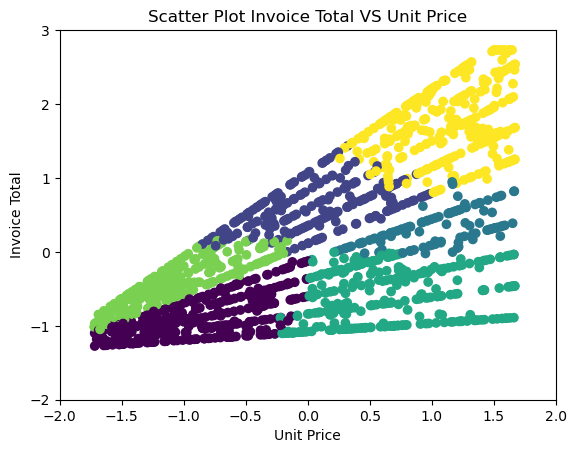

In [83]:
plt.scatter(x=df['Unit price_standardized'],y=df['Total_standardized'],c=df['optimum_clusters'])
plt.xlim(-2,2)
plt.ylim(-2,3)
plt.title('Scatter Plot Invoice Total VS Unit Price')
plt.xlabel('Unit Price')
plt.ylabel('Invoice Total')
plt.show()

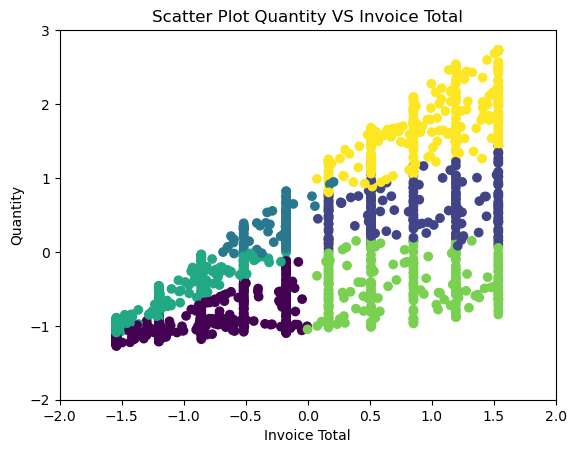

In [84]:
plt.scatter(x=df['Quantity_standardized'],y=df['Total_standardized'],c=df['optimum_clusters'])
plt.xlim(-2,2)
plt.ylim(-2,3)
plt.title('Scatter Plot Quantity VS Invoice Total')
plt.xlabel('Invoice Total')
plt.ylabel('Quantity')
plt.show()

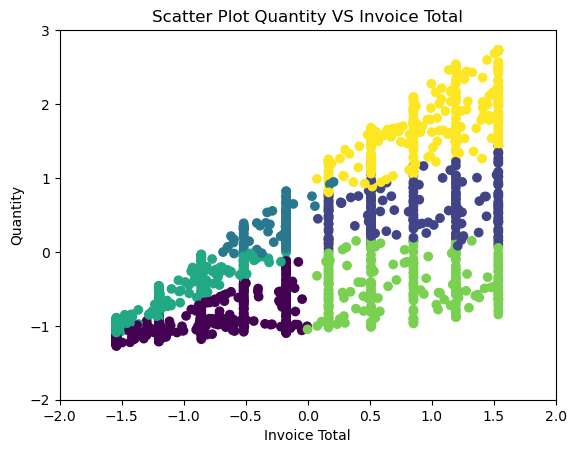

In [85]:
plt.scatter(x=df['Quantity_standardized'],y=df['Total_standardized'],c=df['optimum_clusters'])
plt.xlim(-2,2)
plt.ylim(-2,3)
plt.title('Scatter Plot Quantity VS Invoice Total')
plt.xlabel('Invoice Total')
plt.ylabel('Quantity')
plt.show()